In [2]:
import torchvision

In [3]:
import torch
import torch.optim as optim
import torch.nn as nn

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import numpy as np

In [5]:
import cv2

In [6]:
from torchvision import models, transforms

In [7]:
vgg = models.vgg19(pretrained=True).features

In [8]:
for param in vgg.parameters():
    param.requires_grad_(False)

In [9]:
def load_image(image_path, max_size=400, shape=None):
    image = Image.open(image_path).convert("RGB")
    if max(image.size)>max_size:
        size=max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size=shape
    
    tfms = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((.5,.5,.5),(.5,.5,.5))
        
    ])
    
    image = tfms(image).unsqueeze(0)
    return image

In [10]:
content = load_image("sofi_fam.jpeg")
style = load_image("kandinsky_style.jpg", shape = content.shape[-2:])

In [11]:
import pathlib as p

In [12]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

(-0.5, 597.5, 399.5, -0.5)

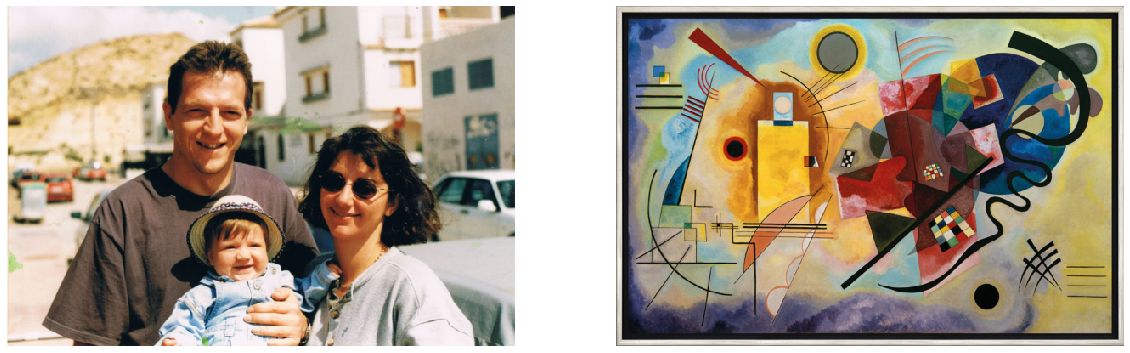

In [13]:
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(20,10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')

In [14]:
def get_features(image,model):
    layers = {
        "0":"conv1_1",
        "5":"conv2_1",
        "10":"conv3_1",
        "19":"conv4_1",
        "21":"conv4_2", #content extraction
        "28":"conv5_1"
    }
    
    features={}
    
    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image
            
    return features
        

In [15]:
content_features = get_features(content,vgg)

In [16]:
style_features = get_features(style, vgg)

In [17]:
def gram_matrix(tensor):
    b,d,h,w = tensor.size()
    tensor = tensor.view(d,h*w)
    gram = torch.mm(tensor, tensor.t())
    return gram
    

In [18]:
style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features}

In [19]:
style_weights = {"conv1_1":1.0,
        "conv2_1":.75,
        "conv3_1":.2,
        "conv4_1":.2,
        "conv5_1":.2}

In [20]:
content_weight=1
style_weight = 1e6

In [21]:
target = content.clone().requires_grad_(True)

In [22]:
show_every=500
optimizer = optim.Adam([target],lr=.003)
steps =4000

In [23]:
height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300,height,width, channels))
capture_frame = steps/300
counter = 0

In [ ]:
for ii in range(1,steps+1):
    target_features = get_features(target,vgg)
    content_loss = torch.mean((target_features['conv4_2']- content_features['conv4_2'])**2)
    style_loss =0
    
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer]* torch.mean((target_gram - style_gram)**2)
        _,d,h,w = target_feature.shape
        style_loss += layer_style_loss / (d*h*w)
        
    total_loss = content_weight*content_loss + style_weight*style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if ii%show_every==0:
        print("Total loss ",total_loss.item())
        print("Iteration: ",ii)
        plt.imshow(im_convert(target))
        plt.axis("off")
        plt.show()
        
    if ii%capture_frame==0:
        image_array[counter] = im_convert(target)
        counter+=1
    

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (20,10))
ax1.imshow(im_convert(content))
ax1.axis("off")
ax2.imshow(im_convert(style))
ax2.axis("off")
ax3.imshow(im_convert(target))
ax3.axis("off")

In [ ]:
final = Image.fromarray((target * 255).astype(np.uint8))

In [ ]:
final.save("final.png","PNG")